# InceptionV3

In [1]:
import pandas as pd
import numpy as np
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD
from keras import backend as K

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# 影像維度
img_width, img_height = 299, 299

train_data_dir = 'D:/Anaconda3/Scripts/5 上課資料/電腦視覺與人機互動/20191031HW/cats_and_dogs_small/train'
validation_data_dir = 'D:/Anaconda3/Scripts/5 上課資料/電腦視覺與人機互動/20191031HW/cats_and_dogs_small/validation'
nb_train_samples = 2000
nb_validation_samples = 800
batch_size = 2

In [3]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [4]:
base_model = InceptionV3(weights='imagenet', include_top=False)

# 添加全域空間平均池化層
x = base_model.output
x = GlobalAveragePooling2D()(x)
# 增加全連階層
x = Dense(1024, activation='relu', name='fc1')(x)
prediction = Dense(2, activation='softmax', name='predictions')(x)
model = Model(inputs=base_model.input, outputs=prediction)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [5]:
# 凍結所有層(除了Bottleneck Layers以外)來進行微調
for layer in model.layers:
    if layer.name in ['predictions']:
        continue
    layer.trainable = False

In [6]:
df = pd.DataFrame(([layer.name, layer.trainable] for layer in model.layers), columns=['layer', 'trainable'])
df

,layer,trainable
0,input_1,False
1,conv2d_1,False
2,batch_normalization_1,False
3,activation_1,False
4,conv2d_2,False
5,batch_normalization_2,False
6,activation_2,False
7,conv2d_3,False
8,batch_normalization_3,False
9,activation_3,False


In [7]:
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(directory='D:/Anaconda3/Scripts/5 上課資料/電腦視覺與人機互動/20191031HW/cats_and_dogs_small/train',
                                                    target_size=[img_width, img_height],
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow_from_directory(directory='D:/Anaconda3/Scripts/5 上課資料/電腦視覺與人機互動/20191031HW/cats_and_dogs_small/validation',
                                                              target_size=[img_width, img_height],
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples // batch_size,
        validation_data = validation_generator,
        validation_steps = validation_generator.samples // batch_size,
        epochs = 20)

model.save('model-inceptionv3-final.h5')

Epoch 1/20
1000/1000 [==============================] - 155s 155ms/step - loss: 0.5221 - acc: 0.7265 - val_loss: 8.0460 - val_acc: 0.5000
Epoch 2/20
1000/1000 [==============================] - 146s 146ms/step - loss: 0.4833 - acc: 0.7555 - val_loss: 7.6949 - val_acc: 0.5080
Epoch 3/20
1000/1000 [==============================] - 138s 138ms/step - loss: 0.4716 - acc: 0.7625 - val_loss: 8.0412 - val_acc: 0.5010
Epoch 4/20
1000/1000 [==============================] - 137s 137ms/step - loss: 0.4746 - acc: 0.7570 - val_loss: 7.8725 - val_acc: 0.5060
Epoch 5/20
1000/1000 [==============================] - 134s 134ms/step - loss: 0.4491 - acc: 0.7650 - val_loss: 7.8230 - val_acc: 0.5070
Epoch 6/20
1000/1000 [==============================] - 133s 133ms/step - loss: 0.4475 - acc: 0.7690 - val_loss: 7.3503 - val_acc: 0.5150
Epoch 7/20
1000/1000 [==============================] - 133s 133ms/step - loss: 0.4439 - acc: 0.7765 - val_loss: 7.9475 - val_acc: 0.5050
Epoch 8/20
1000/1000 [============

In [9]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)
for layer in model.layers[:172]:
    layer.trainable = False
for layer in model.layers[172:]:
    layer.trainable = True

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [10]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples // batch_size,
        validation_data = validation_generator,
        validation_steps = validation_generator.samples // batch_size,
        epochs = 20)

model.save('model-inceptionv3-final2.h5')

Epoch 1/20
1000/1000 [==============================] - 239s 239ms/step - loss: 1.2781 - acc: 0.6990 - val_loss: 7.8385 - val_acc: 0.5100
Epoch 2/20
1000/1000 [==============================] - 232s 232ms/step - loss: 0.3086 - acc: 0.8605 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/20
1000/1000 [==============================] - 232s 232ms/step - loss: 0.1861 - acc: 0.9325 - val_loss: 7.8990 - val_acc: 0.5020
Epoch 4/20
1000/1000 [==============================] - 232s 232ms/step - loss: 0.1582 - acc: 0.9355 - val_loss: 6.4260 - val_acc: 0.5210
Epoch 5/20
1000/1000 [==============================] - 232s 232ms/step - loss: 0.1392 - acc: 0.9425 - val_loss: 8.0293 - val_acc: 0.5010
Epoch 6/20
1000/1000 [==============================] - 232s 232ms/step - loss: 0.1198 - acc: 0.9550 - val_loss: 7.4270 - val_acc: 0.5150
Epoch 7/20
1000/1000 [==============================] - 231s 231ms/step - loss: 0.1033 - acc: 0.9585 - val_loss: 8.0533 - val_acc: 0.5000
Epoch 8/20
1000/1000 [============

<Figure size 640x480 with 1 Axes>

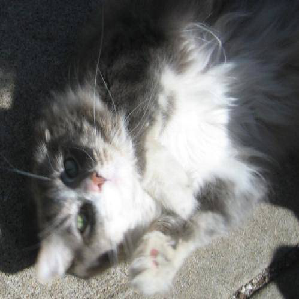

<Figure size 640x480 with 1 Axes>

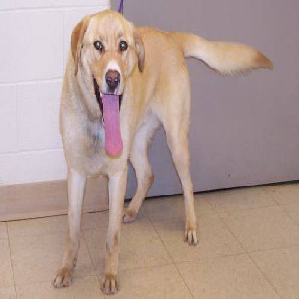

In [11]:
from IPython.display import display
import matplotlib.pyplot as plt

X_val_sample, _ = next(validation_generator)
y_pred = model.predict(X_val_sample)

nb_sample = 4
for x, y in zip(X_val_sample[:nb_sample], y_pred[:nb_sample]):
    s = pd.Series({'Cat': 1-np.max(y), 'Dog': np.max(y)})
    axes = s.plot(kind='bar')
    axes.set_xlabel('Class')
    axes.set_ylabel('Probability')
    axes.set_ylim([0, 1])
    plt.show()

    img = array_to_img(x)
    display(img)

In [12]:
scores = model.evaluate_generator(generator=validation_generator, steps=validation_generator.samples // batch_size)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (scores[0]/100, scores[1]*100))


Loss: 0.08, Accuracy: 50.00%


Save image/Inceptionv3_acc
Save image/Inceptionv3_loss


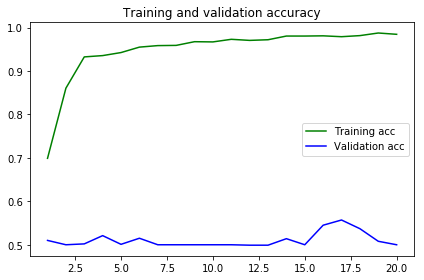

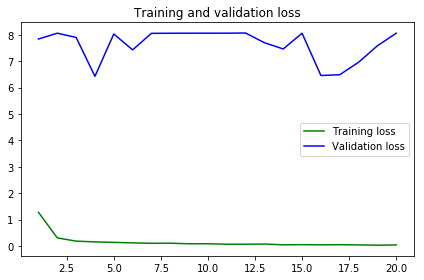

In [13]:
modelname = 'Inceptionv3'

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

metrics = 'acc'
filename = 'image/'+ modelname + '_' + metrics
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(filename, dpi=300)
print('Save',filename)
plt.figure()

metrics = 'loss'
filename = 'image/'+ modelname + '_' + metrics
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(filename, dpi=300)
print('Save',filename)
plt.show()